# 3dasm Project

## Agenda
## Single Fidelity
- simulated data and experimental data separately
- different kernels, optimizers
## Multi Fidelity
- scikit-learn vs gpytorch
1. [Phase 1: Gaussian Process on Simulated Data only](#Phase-1:-Gaussian-Process-on-Simulated-Data-only)
2. [Training with Different Kernels: common Constant*RBF kernel with an optimizer fmin_1_bfgs_b](#Training-with-Different-Kernels:-common-Constant*RBF-kernel-with-an-optimizer-fmin_1_bfgs_b)
3. [Training with Different Kernels: ExpSineSquared with an optimizer fmin_1_bfgs_b](#Training-with-Different-Kernels:-ExpSineSquared-with-an-optimizer-fmin_1_bfgs_b)
4. [Training with Different Kernels: Matern with an optimizer fmin_1_bfgs_b](#Training-with-Different-Kernels:-Matern-with-an-optimizer-fmin_1_bfgs_b)
5. [Training with Different Kernels: common Constant*RBF kernel With No Optimizer](#Training-with-Different-Kernels:-common-Constant*RBF-kernel-With-No-Optimizer)
6. [Training with Different Kernels: ExpSineSquared with no optimizer](#Training-with-Different-Kernels:-ExpSineSquared-with-no-optimizer)
7. [Training with Different Kernels: Matern with no optimizer](#Training-with-Different-Kernels:-Matern-with-no-optimizer)
8. [Phase 1.5: Gaussian Process on Experimental Data Only](#Phase-1.5:-Gaussian-Process-on-Experimental-Data-Only)
9. [Training with Different kernels: common Constant*RBF kernel with an optimizer fmin_1_bfgs_b](#Training-with-Different-kernels:-common-Constant*RBF-kernel-with-an-optimizer-fmin_1_bfgs_b)
10. [Training with Different Kernels: ExpSineSquared with an optimizer fmin_1_bfgs_b](#Training-with-Different-Kernels:-ExpSineSquared-with-an-optimizer-fmin_1_bfgs_b)
11. [Training with Different Kernels: Matern with an optimizer fmin_1_bfgs_b](#Training-with-Different-Kernels:-Matern-with-an-optimizer-fmin_1_bfgs_b)
12. [Phase 2: Training with Simulation Data and Testing with Experimental Data](#Phase-2:-Training-with-Simulation-Data-and-Testing-with-Experimental-Data)
13. [Constant Kernel and  f_min optimizer](#Constant-Kernel-and-f_min-optimizer)
14. [Matern kernel with no optimizer](#Matern-kernel-with-no-optimizer)
15. [Phase 3: Multi-fidelity Gaussian Process](#Phase-3:-Multi-fidelity-Gaussian-Process)
16. [Phase 4: Error Metrics](#Phase-4:-Error-Metrics)

### Importing necessary packages

In [4]:
import matplotlib.pyplot as plt # import plotting tools to create figures
import numpy as np # import numpy to handle a lot of things!
from IPython.display import display, Math # to print with Latex math
import pandas as pd

%config InlineBackend.figure_format = "retina" # render higher resolution images in the notebook
plt.rcParams["figure.figsize"] = (8,4) # rescale figure size appropriately for slides

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ExpSineSquared, ConstantKernel, WhiteKernel
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [6]:
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 12,
        } # using this property entry for nice plotting labels

<a id='Phase 1: Gaussian Process on Simulated Data only'></a>

## Phase 1: Gaussian Process on Simulated Data only

In [7]:
# import simulated data for the specific shear modulus and viscosity corresponding to the experimental data, pre-processing in matlab (including scaling)
sim_df = pd.read_csv("../Simulation_Data_0.107_13900.csv") # read pandas DataFrame
print("Show the simulated DataFrameused for training data:\n", sim_df)

Show the simulated DataFrameused for training data:
            -1         1
0   -0.999999  1.000000
1   -0.999998  1.000000
2   -0.999997  1.000000
3   -0.999996  1.000000
4   -0.999992  1.000000
..        ...       ...
679  0.987099 -0.394078
680  0.990324 -0.395279
681  0.993549 -0.396498
682  0.996775 -0.397697
683  1.000000 -0.398838

[684 rows x 2 columns]


In [8]:
Data_x_sim = sim_df.iloc[:,0] # select the input values from the dataframe into Data_x
Data_y_sim = sim_df.iloc[:,1] # select the output values from the dataframe into Data_y
print("Data_x is:\n",Data_x_sim)
print("\nData_y is:\n",Data_y_sim)

Data_x is:
 0     -0.999999
1     -0.999998
2     -0.999997
3     -0.999996
4     -0.999992
         ...   
679    0.987099
680    0.990324
681    0.993549
682    0.996775
683    1.000000
Name: -1, Length: 684, dtype: float64

Data_y is:
 0      1.000000
1      1.000000
2      1.000000
3      1.000000
4      1.000000
         ...   
679   -0.394078
680   -0.395279
681   -0.396498
682   -0.397697
683   -0.398838
Name: 1, Length: 684, dtype: float64


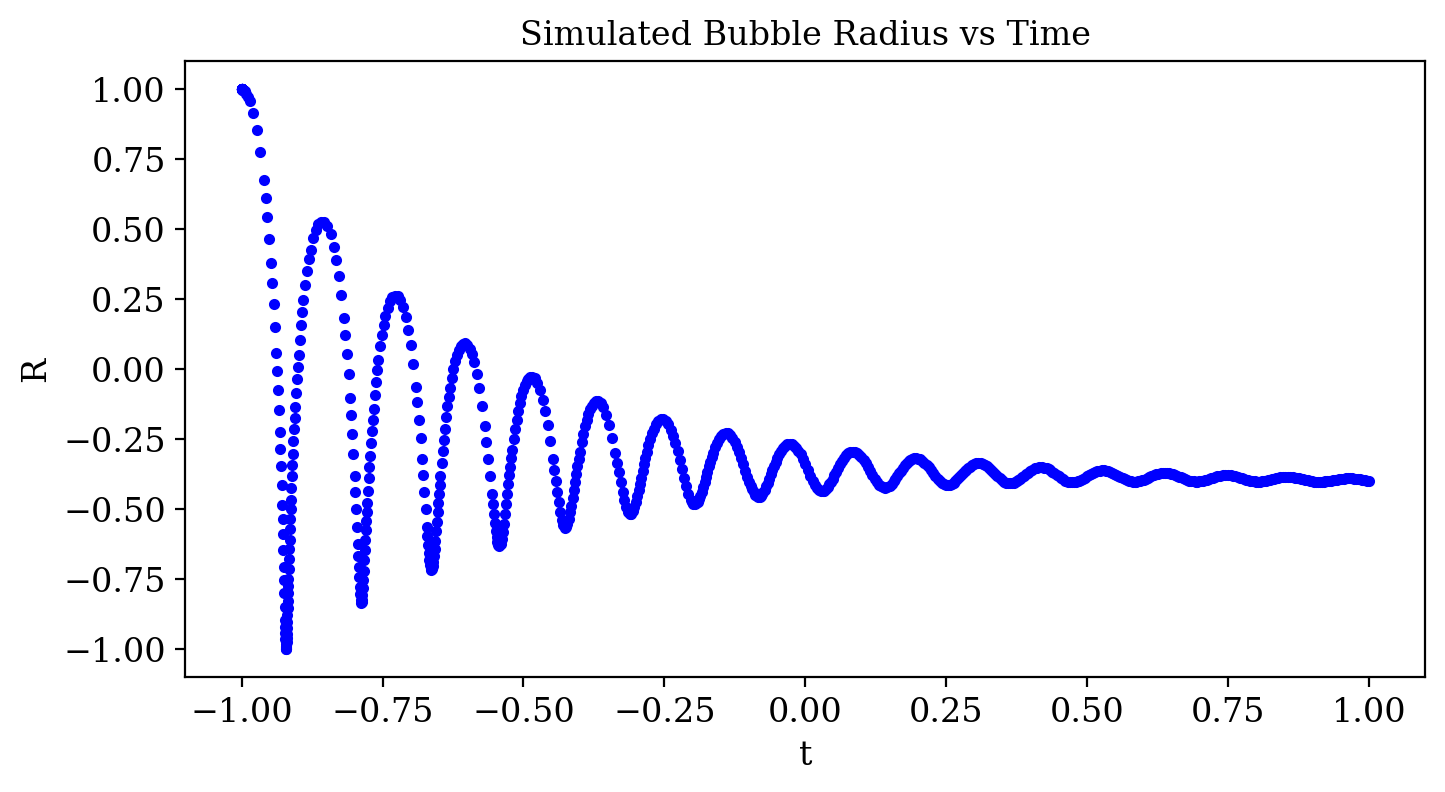

In [12]:
fig_sim_data, ax_sim_data = plt.subplots() # create a plot
ax_sim_data.plot(Data_x_sim, Data_y_sim, 'b.')
#ax_sim_data.set_xlabel("t", fontsize=20) # create x-axis label with font size 20
#ax_sim_data.set_ylabel("R", fontsize=20) # create y-axis label with font size 20
ax_sim_data.set_xlabel("t", font) # create x-axis label with font size 20
ax_sim_data.set_ylabel("R", font) # create y-axis label with font size 20
ax_sim_data.set_title("Simulated Bubble Radius vs Time", font); # create title with font size 20
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
plt.savefig("sim_data.png", bbox_inches="tight")
plt.show(fig_sim_data)

In [13]:
n_data = 50 # number of points in our dataset
testset_ratio_sim = 0.10 # ratio of test set points from the dataset

X_data_sim = np.reshape(Data_x_sim,(-1,1)) # a 2D array that scikit-learn likes

seed = 1987 # set a random seed so that everyone gets the same result
np.random.seed(seed)

# Let's split into 10% training points and the rest for testing:
X_train_sim, X_test_sim, y_train_sim, y_test_sim = train_test_split(X_data_sim,
                                    Data_y_sim, test_size=testset_ratio_sim,
                                    random_state=seed)

x_train_sim = X_train_sim.ravel() # just for plotting later
x_test_sim = X_test_sim.ravel() # just for plotting later

#print("Here's a print of X_train:\n", X_train_sim)

In [14]:
# Define points used for plotting
n_max_sim = np.max(X_data_sim)
n_min_sim = np.min(X_data_sim)
n_plot_sim = 500 # number of points used for plotting the model
x_plot_sim = np.linspace(n_min_sim, n_max_sim, n_plot_sim) # create dataset with uniformly spaced points
X_plot_sim = np.reshape(x_plot_sim,(-1,1)) # a 2D array that scikit-learn likes

In [21]:
##don't need to scale as the data was already normalized so that t is in (0,5) and R is in (0,1)

#scaling the simulated data for the GPR algorithm using MinMaxScaler
##X_train_sim = X_train_sim.reshape(-1, 1) # recall that we need to convert the 1D array vector into a 2D array vector
##X_test_sim= X_test_sim.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
##X_data_sim = X_data_sim.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
#
#scaler_x_sim = MinMaxScaler(feature_range=(0,1))
#scaler_x_sim.fit(X_train_sim) # fit the scaler to the input data
#X_train_sim_scaled=scaler_x_sim.transform(X_train_sim) # scale the input training data
#X_test_sim_scaled=scaler_x_sim.transform(X_test_sim) # scale the input testing data
#X_data_sim_scaled=scaler_x_sim.transform(X_data_sim) # scale the input data (the whole dataset)


#check
#idx = 0 # Choose the point you want to check the value (we could also plot the entire dataset.)
print("X_data_sim[%i] is =" % idx, X_data_sim[idx])
#print("X_data_sim_scaled[%i] is =" % idx, X_data_sim_scaled[idx])

X_data_sim[0] is = [-0.99999909]


In [22]:
##don't need to scale as the data was already normalized so that t is in (0,5) and R is in (0,1)

# Now scaling outputs also using MinMaxScaler
##y_data_sim = np.reshape(Data_y_sim,(-1,1)) # a 2D array that scikit-learn likes

##y_train_sim = y_train_sim.values.reshape(-1, 1) # recall that we need to convert the 1D array vector into a 2D array vector
##y_test_sim= y_test_sim.values.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
#y_data_sim = Data_y_sim.values.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
#y_train_sim = y_train_sim.reshape(-1, 1) # recall that we need to convert the 1D array vector into a 2D array vector
#y_test_sim= y_test_sim.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
#y_data_sim = y_data_sim.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
#
#scaler_y_sim = MinMaxScaler(feature_range=(0,1))
#scaler_y_sim.fit(y_train_sim) # fit the scaler to the output data
#
#y_train_sim_scaled=scaler_y_sim.transform(y_train_sim) # scale the output training data
#y_test_sim_scaled=scaler_y_sim.transform(y_test_sim)  # scale the output testing data
#y_data_sim_scaled=scaler_y_sim.transform(y_data_sim) # scale the output data (the whole dataset)

#idx = 0 # Choose the point you want to check the value (we could also plot the entire dataset.)
print("y_data_sim[%i] is =" % idx, y_data_sim[idx])
#print("y_data_sim_scaled[%i] is =" % idx, y_data_sim_scaled[idx])

y_data_sim[0] is = [1.]


<b id='Training with Different Kernels: common Constant*RBF kernel with an optimizer fmin_1_bfgs_b'></b>

### Training with Different Kernels: common Constant*RBF kernel with an optimizer fmin_1_bfgs_b

In [19]:
# Define the kernel function
kernel_rbf = ConstantKernel(1.0, (1e-3, 1e5)) * RBF(10, (1e-2, 1e2)) # This is the very common Constant*RBF kernel

gp_model_sim = GaussianProcessRegressor(kernel=kernel_rbf, alpha=1e-6, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)
#gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, optimizer=None, n_restarts_optimizer=20)

# Fit to data to determine parameters to train the model on SCALED inputs and outputs
gp_model.fit(X_train_sim_scaled, y_train_sim_scaled)

# Make the prediction on the entire dataset (for plotting)

y_plot_pred_sim, sigma_plot_sim = gp_model_sim.predict(X_plot_sim, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_sim, sigma_sim = gp_model_sim.predict(X_test_sim, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_rbf = mean_squared_error(y_test_sim,y_pred_sim)
r2_rbf = r2_score(y_test_sim,y_pred_sim)
print(f"For Constant*RBF kernel, MSE = {mse_rbf:.4f},R^2 = {r2_rbf:.4f}")

/oscar/home/mcarcana/3dasm_project/lib/python3.9/site-packages/sklearn/gaussian_process/_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


For Constant*RBF kernel, MSE = 0.0003,R^2 = 0.9960


/oscar/home/mcarcana/3dasm_project/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 0.01. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [20]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_sim.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper left', fontsize=12)
fig1.set_size_inches(8,8)
plt.savefig("sim_RBF_optimizer.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

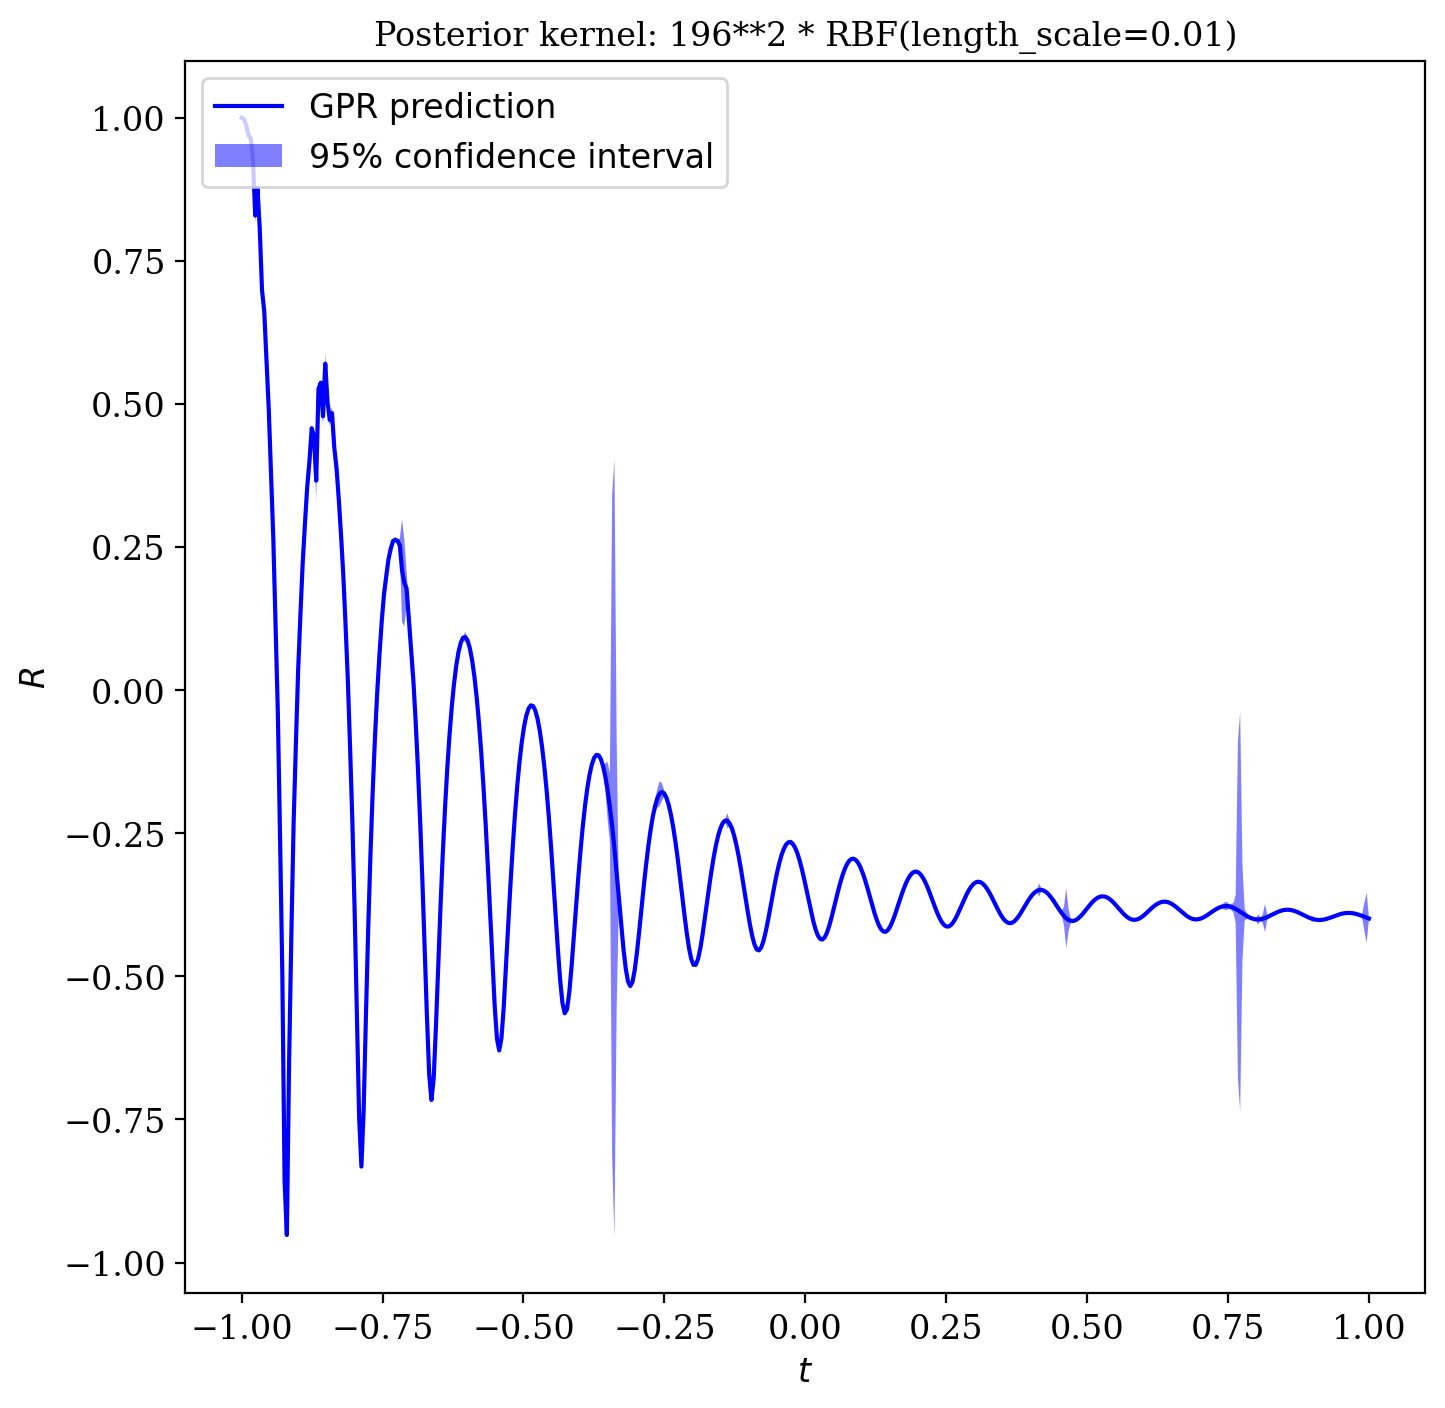

In [21]:
fig1

In [22]:
# Plot the function, the prediction and the 95% confidence interval
fig2, ax2 = plt.subplots()

ax2.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax2.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax2.plot(x_train_sim, y_train_sim, 'ro', markersize=6, label="training points") # Plot train data
ax2.plot(x_test_sim, y_test_sim, 'kX', markersize=6, label="testing points") # Plot test points

ax2.set_xlabel('$t$', font)
ax2.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax2.set_title("Posterior kernel: %s"
              % gp_model_sim.kernel_, font) # Show in the title the value of the hyperparameters
#ax2.set_ylim(-10, 15) # just to provide more space for the legend
ax2.legend(loc='upper left', fontsize=15)
fig2.set_size_inches(8,8)
plt.savefig("sim_RBF_optimizer_points.png", bbox_inches="tight")
plt.close(fig2) # close the plot to see it in next cell

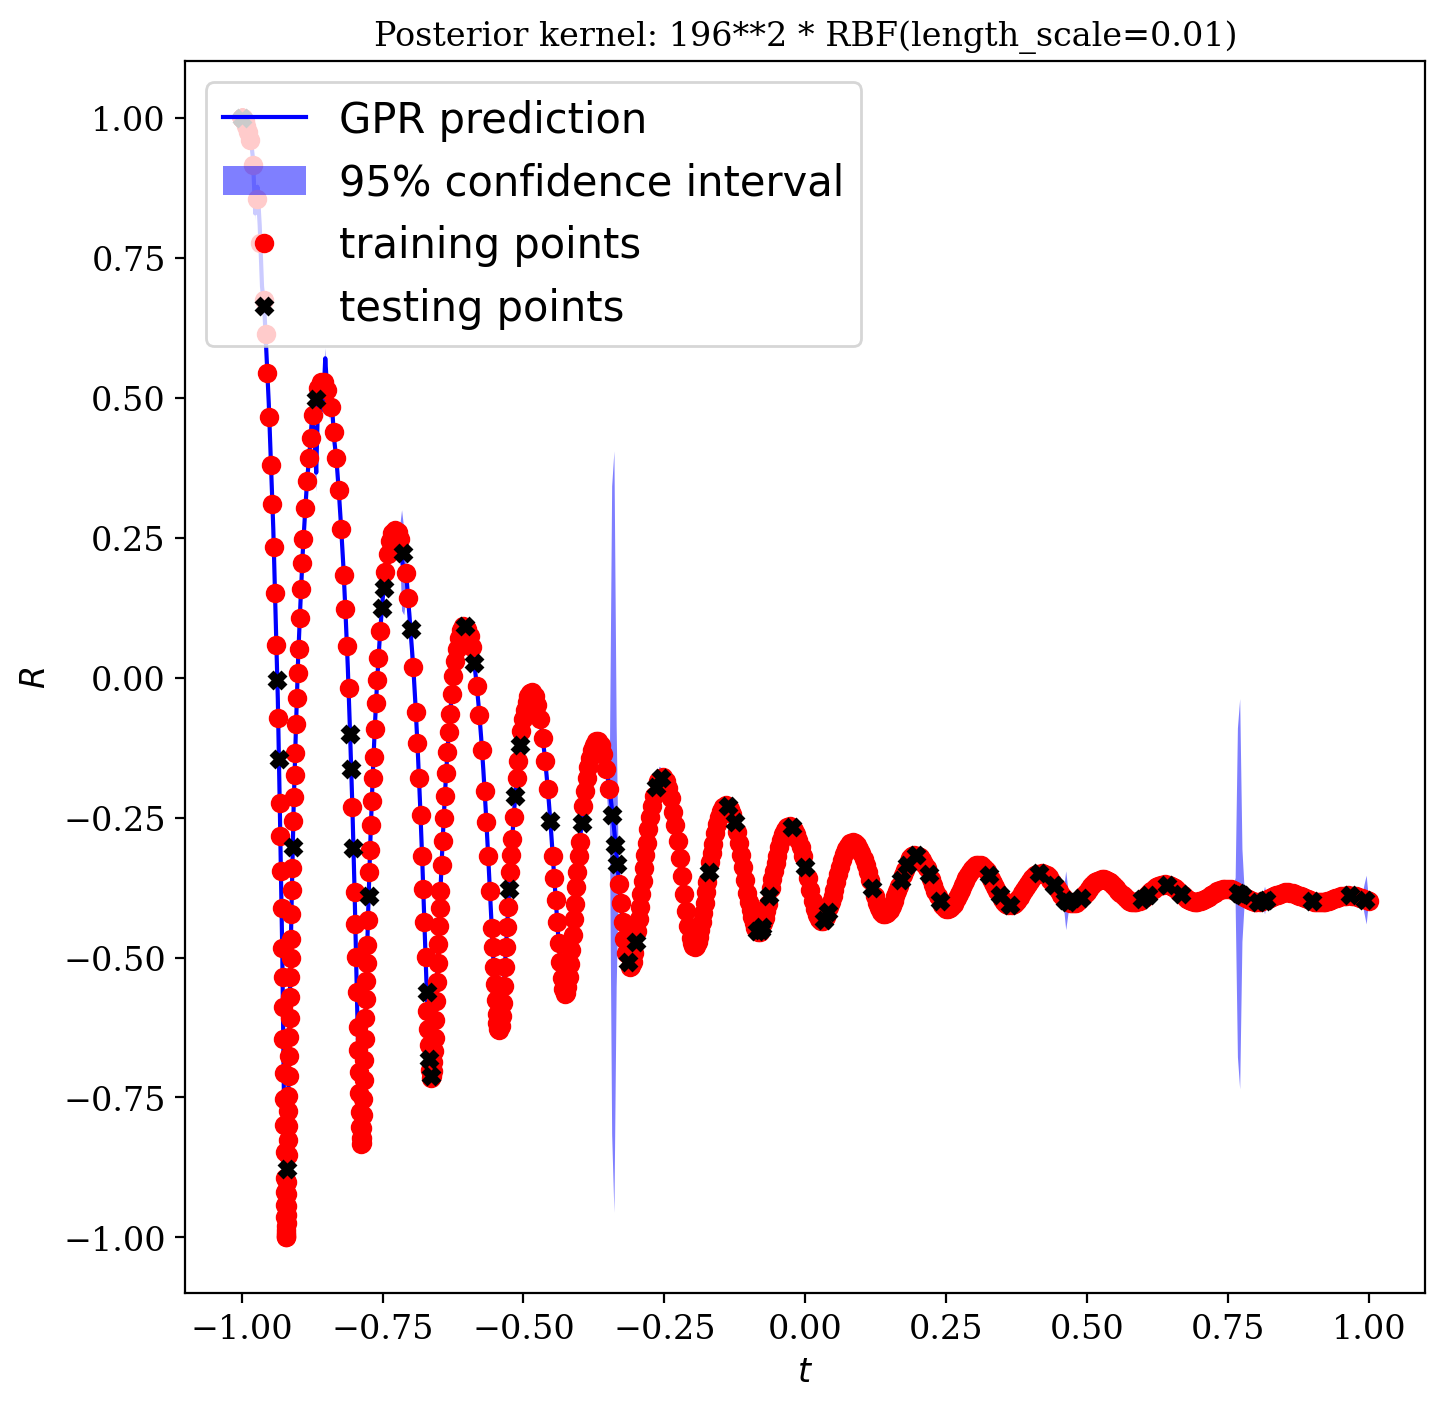

In [23]:
fig2

<c id='Training with Different Kernels: ExpSineSquared with an optimizer fmin_1_bfgs_b'></c>

### Training with Different Kernels: ExpSineSquared with an optimizer fmin_1_bfgs_b

In [ ]:
# Define the kernel function
kernel_ess = ExpSineSquared(length_scale=3.0, periodicity=3.14,
                        length_scale_bounds=(0.1, 10.0),
                        periodicity_bounds=(0.1, 10)) * RBF(3.0, (1e-2, 1e2))

gp_model_sim = GaussianProcessRegressor(kernel=kernel_ess, alpha=1e-6, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)
#gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, optimizer=None, n_restarts_optimizer=20)

# Fit to data to determine parameters
gp_model_sim.fit(X_train_sim, y_train_sim)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_sim, sigma_plot_sim = gp_model_sim.predict(X_plot_sim, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_sim, sigma_sim = gp_model_sim.predict(X_test_sim, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_ess = mean_squared_error(y_test_sim,y_pred_sim)
r2_ess = r2_score(y_test_sim,y_pred_sim)
print(f"For ExpSineSquared kernel, MSE = {mse_ess:.4f},R^2 = {r2_ess:.4f}")

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_sim.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)
plt.savefig("sim_ESS_optimizer.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

In [ ]:
# Plot the function, the prediction and the 95% confidence interval
fig2, ax2 = plt.subplots()

ax2.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax2.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax2.plot(x_train_sim, y_train_sim, 'ro', markersize=6, label="training points") # Plot train data
ax2.plot(x_test_sim, y_test_sim, 'kX', markersize=6, label="testing points") # Plot test points

ax2.set_xlabel('$t$', font)
ax2.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax2.set_title("Posterior kernel: %s"
              % gp_model_sim.kernel_, font) # Show in the title the value of the hyperparameters
#ax2.set_ylim(-10, 15) # just to provide more space for the legend
ax2.legend(loc='upper left', fontsize=15)
fig2.set_size_inches(8,8)
plt.savefig("sim_ESS_optimizer_points.png", bbox_inches="tight")
plt.close(fig2) # close the plot to see it in next cell

In [ ]:
fig2

<d id='Training with Different Kernels: Matern with an optimizer fmin_1_bfgs_b'></d>

### Training with Different Kernels: Matern with an optimizer fmin_1_bfgs_b

In [ ]:
# Define the kernel function
kernel_M = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=1.5)

gp_model_sim = GaussianProcessRegressor(kernel=kernel_M, alpha=1e-6, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)
#gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, optimizer=None, n_restarts_optimizer=20)

# Fit to data to determine parameters
gp_model_sim.fit(X_train_sim, y_train_sim)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_sim, sigma_plot_sim = gp_model_sim.predict(X_plot_sim, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_sim, sigma_sim = gp_model_sim.predict(X_test_sim, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_M = mean_squared_error(y_test_sim,y_pred_sim)
r2_M = r2_score(y_test_sim,y_pred_sim)
print(f"For Matern kernel, MSE = {mse_M:.4f},R^2 = {r2_M:.4f}")

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_sim.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)
plt.savefig("sim_Matern_optimizer.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

In [ ]:
# Plot the function, the prediction and the 95% confidence interval
fig2, ax2 = plt.subplots()

ax2.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax2.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax2.plot(x_train_sim, y_train_sim, 'ro', markersize=6, label="training points") # Plot train data
ax2.plot(x_test_sim, y_test_sim, 'kX', markersize=6, label="testing points") # Plot test points

ax2.set_xlabel('$t$', font)
ax2.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax2.set_title("Posterior kernel: %s"
              % gp_model_sim.kernel_, font) # Show in the title the value of the hyperparameters
#ax2.set_ylim(-10, 15) # just to provide more space for the legend
ax2.legend(loc='upper left', fontsize=15)
fig2.set_size_inches(8,8)
plt.savefig("sim_Matern_optimizer_points.png", bbox_inches="tight")
plt.close(fig2) # close the plot to see it in next cell

In [ ]:
fig2

<e id='Training with Different Kernels: common Constant*RBF kernel With No Optimizer'></e>

### Training with Different Kernels: common Constant*RBF kernel With No Optimizer

In [ ]:
# Define the kernel function
kernel_rbf_noopt = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the very common Constant*RBF kernel

gp_model_rbf_noopt = GaussianProcessRegressor(kernel=kernel_rbf_noopt, alpha=1e-6, optimizer=None, n_restarts_optimizer=20)

# Fit to data to determine parameters
gp_model_rbf_noopt.fit(X_train_sim, y_train_sim)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_sim, sigma_plot_sim = gp_model_rbf_noopt.predict(X_plot_sim, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_sim, sigma_sim = gp_model_rbf_noopt.predict(X_test_sim, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_rbf_noopt = mean_squared_error(y_test_sim,y_pred_sim)
r2_rbf_noopt = r2_score(y_test_sim,y_pred_sim)
print(f"For Constant*RBF kernel without an optimizer, MSE = {mse_rbf_noopt:.4f},R^2 = {r2_rbf_noopt:.4f}")

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_rbf_noopt.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)
plt.savefig("sim_RBF_no_optimizer_points.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

<f id='Training with Different Kernels: ExpSineSquared with no optimizer'></f>

### Training with Different Kernels: ExpSineSquared with no optimizer

In [ ]:
# Define the kernel function
kernel_ess_noopt = ExpSineSquared(length_scale=3.0, periodicity=3.14,
                        length_scale_bounds=(0.1, 10.0),
                        periodicity_bounds=(0.1, 10)) * RBF(3.0, (1e-2, 1e2))

gp_model_ess_noopt = GaussianProcessRegressor(kernel=kernel_ess_noopt, alpha=1e-6, optimizer=None, n_restarts_optimizer=20)

# Fit to data to determine parameters
gp_model_ess_noopt.fit(X_train_sim, y_train_sim)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_sim, sigma_plot_sim = gp_model_ess_noopt.predict(X_plot_sim, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_sim, sigma_sim = gp_model_ess_noopt.predict(X_test_sim, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_ess_noopt = mean_squared_error(y_test_sim,y_pred_sim)
r2_ess_noopt = r2_score(y_test_sim,y_pred_sim)
print(f"For ExpSineSquared kernel without an optimizer, MSE = {mse_ess_noopt:.4f},R^2 = {r2_ess_noopt:.4f}")

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_ess_noopt.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper left', fontsize=15)
plt.savefig("sim_ESS_no_optimizer.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

<g id='Training with Different Kernels: Matern with no optimizer'></g>

### Training with Different Kernels: Matern with no optimizer

In [ ]:
# Define the kernel function
kernel_m_noopt = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=1.5)

gp_model_m_noopt = GaussianProcessRegressor(kernel=kernel_m_noopt, alpha=1e-6, optimizer=None, n_restarts_optimizer=20)

# Fit to data to determine parameters
gp_model_m_noopt.fit(X_train_sim, y_train_sim)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_sim, sigma_plot_sim = gp_model_m_noopt.predict(X_plot_sim, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_sim, sigma_sim = gp_model_m_noopt.predict(X_test_sim, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_m_noopt = mean_squared_error(y_test_sim,y_pred_sim)
r2_m_noopt = r2_score(y_test_sim,y_pred_sim)
print(f"For Matern kernel without an optimizer, MSE = {mse_m_noopt:.4f},R^2 = {r2_m_noopt:.4f}")

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_sim, y_plot_pred_sim, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_sim, x_plot_sim[::-1]]),
         np.concatenate([y_plot_pred_sim - 1.9600 * sigma_plot_sim,
                        (y_plot_pred_sim + 1.9600 * sigma_plot_sim)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_m_noopt.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)
plt.savefig("sim_Matern_no_optimizer.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

### different optimizers? different ratios of training/testing data?

<h id='Phase 1.5: Gaussian Process on Experimental Data Only'></h>

# Phase 1.5: Gaussian Process on Experimental Data Only

In [25]:
#import experimental data from collaborators, pre-processing in matlab (including scaling)
exp_df = pd.read_csv("../normalized_unscaled_Experimental_Data_10PA_.06BIS.csv") # read pandas DataFrame
print("Show the experimental DataFrame used for testing data:\n", exp_df)

Show the experimental DataFrame used for testing data:
      0.0170220398718178  0.999866408529248
0              0.044679           0.998759
1              0.072336           0.996847
2              0.099993           0.994077
3              0.127651           0.990380
4              0.155308           0.985505
..                  ...                ...
176            4.912334           0.163639
177            4.939991           0.159946
178            4.967648           0.156486
179            4.995306           0.154681
180            5.022963           0.155009

[181 rows x 2 columns]


In [26]:
Data_t_exp = exp_df.iloc[:,0]
Data_R_exp = exp_df.iloc[:,1] 
print("Experimental x data is the time:\n",Data_t_exp)
print("Experimental y data is the bubble radius from the camera:\n",Data_R_exp)

Experimental x data is the time:
 0      0.044679
1      0.072336
2      0.099993
3      0.127651
4      0.155308
         ...   
176    4.912334
177    4.939991
178    4.967648
179    4.995306
180    5.022963
Name: 0.0170220398718178, Length: 181, dtype: float64
Experimental y data is the bubble radius from the camera:
 0      0.998759
1      0.996847
2      0.994077
3      0.990380
4      0.985505
         ...   
176    0.163639
177    0.159946
178    0.156486
179    0.154681
180    0.155009
Name: 0.999866408529248, Length: 181, dtype: float64


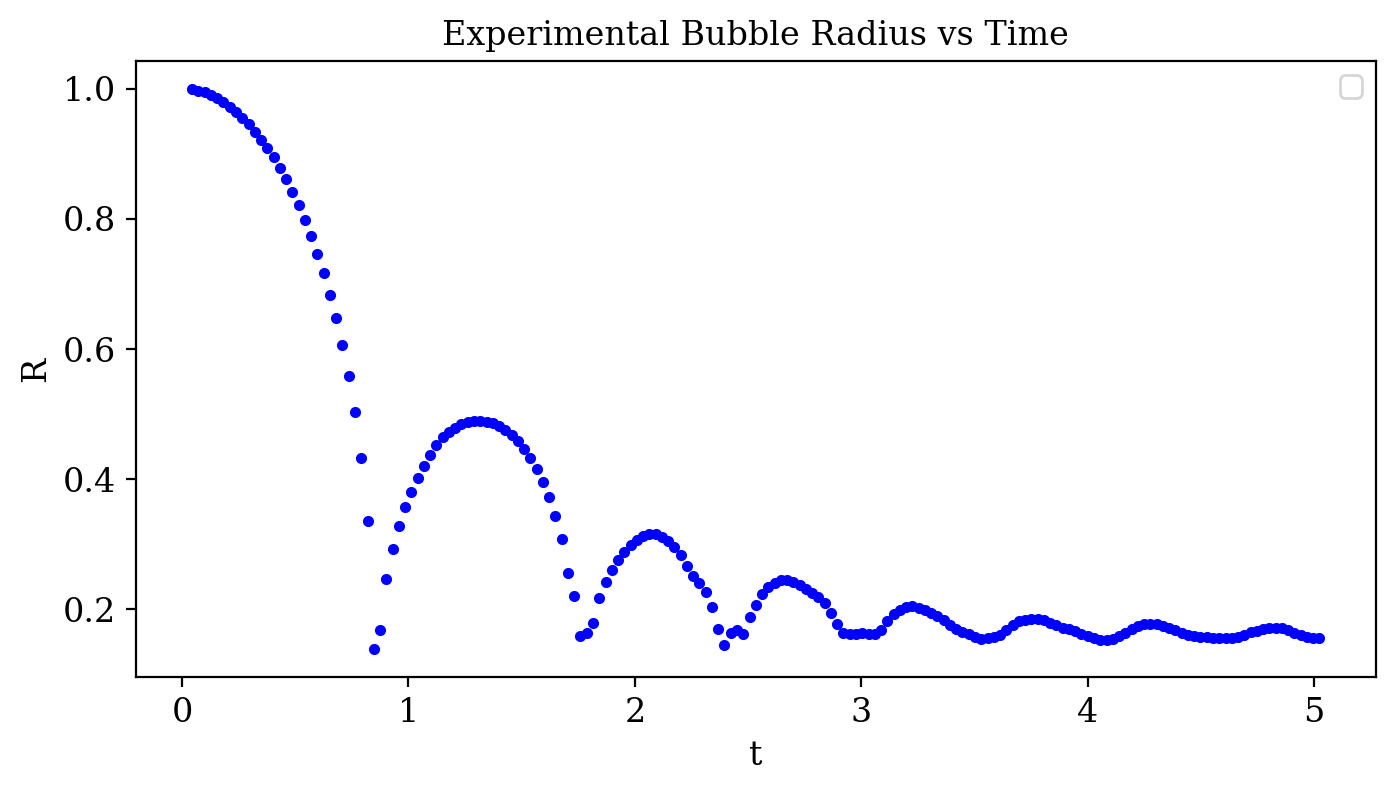

In [27]:
fig_exp_data, ax_exp_data = plt.subplots() # create a plot
ax_exp_data.plot(Data_t_exp, Data_R_exp, 'b.')

ax_exp_data.set_xlabel("t", font) # create x-axis label with font size 20
ax_exp_data.set_ylabel("R", font) # create y-axis label with font size 20
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax_exp_data.set_title("Experimental Bubble Radius vs Time", font); # create title with font size 20

handles, labels = ax_exp_data.get_legend_handles_labels()
ax_exp_data.legend(handles, labels)
plt.savefig("avg_exp_data.png", bbox_inches="tight")
plt.show(fig_exp_data)

In [32]:
n_data = len(Data_t_exp) # number of points in our dataset
testset_ratio = 0.75 # ratio of test set points from the dataset

t_data_exp = np.reshape(Data_t_exp,(-1,1)) # a 2D array that scikit-learn likes

seed = 1987 # set a random seed so that everyone gets the same result
np.random.seed(seed)

# Let's split into 10% training points and the rest for testing:
X_train_exp, X_test_exp, y_train_exp, y_test_exp = train_test_split(t_data_exp,
                                    Data_R_exp, test_size=testset_ratio,
                                    random_state=seed)

x_train_exp = X_train_exp.ravel() # just for plotting later
x_test_exp = X_test_exp.ravel() # just for plotting later

#print("Here's a print of X_train:\n", X_train_exp)

In [33]:
# Define points used for plotting
n_max_exp = np.max(t_data_exp)
n_min_exp = np.min(t_data_exp)
n_plot_exp = 500 # number of points used for plotting the model
n_max_exp = np.max(t_data_exp)
x_plot_exp = np.linspace(n_min_exp, n_max_exp, n_plot_exp) # create dataset with uniformly spaced points
X_plot_exp = np.reshape(x_plot_exp,(-1,1)) # a 2D array that scikit-learn likes

In [34]:
## don't need to scale as the data was already preprocessed so t is in (0,5) and R is in (0,1)

# Scaling inputs with a MinMax Scaler (between 0 and 1):
#scaler_x_exp = MinMaxScaler(feature_range=(-1,1))
#scaler_x_exp.fit(X_train_exp)
#
#X_train_exp_scaled=scaler_x.transform(X_train_exp)
#X_test_exp_scaled=scaler_x.transform(X_test_exp)
#X_data_exp_scaled=scaler_x.transform(t_data_exp)

#check
#idx = 0 # Choose the point you want to check the value (we could also plot the entire dataset.)
#print("X_data_exp[%i] is =" % idx, t_data_exp[idx])
#print("X_data_exp_scaled[%i] is =" % idx, X_data_exp_scaled[idx])

In [35]:
## don't need to scale as the data was already preprocessed so t is in (0,5) and R is in (0,1)

# Now scaling outputs also using MinMaxScaler
y_data_exp = np.reshape(Data_t_exp,(-1,1)) # a 2D array that scikit-learn likes

##y_train_exp = y_train_exp.values.reshape(-1, 1) # recall that we need to convert the 1D array vector into a 2D array vector
##y_test_exp = y_test_exp.values.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
##y_data_exp = y_data_exp.values.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
#y_train_exp = y_train_exp.reshape(-1, 1) # recall that we need to convert the 1D array vector into a 2D array vector
#y_test_exp = y_test_exp.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
#y_data_exp = y_data_exp.reshape(-1, 1)   # recall that we need to convert the 1D array vector into a 2D array vector
#
#scaler_y_exp = MinMaxScaler(feature_range=(0,1))
#scaler_y_exp.fit(y_train_exp) # fit the scaler to the output data
#
#y_train_exp_scaled=scaler_y_exp.transform(y_train_exp) # scale the output training data
#y_test_exp_scaled=scaler_y_exp.transform(y_test_exp)  # scale the output testing data
#y_data_exp_scaled=scaler_y_exp.transform(y_data_exp) # scale the output data (the whole dataset)

#idx = 0 # Choose the point you want to check the value (we could also plot the entire dataset.)
print("y_data_exp[%i] is =" % idx, y_data_exp[idx])
#print("y_data_exp_scaled[%i] is =" % idx, y_data_exp_scaled[idx])

y_data_exp[0] is = [0.04467917]


<i id='Training with Different kernels: common Constant*RBF kernel with an optimizer fmin_1_bfgs_b'></i>

## Training with Different kernels: common Constant*RBF kernel with an optimizer fmin_1_bfgs_b

In [ ]:
# Define the kernel function
kernel_rbf = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the very common Constant*RBF kernel

gp_model_exp_rbf = GaussianProcessRegressor(kernel=kernel_rbf, alpha=1e-2, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)
#gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, optimizer=None, n_restarts_optimizer=20)

# Fit to data to determine parameters
gp_model_exp_rbf.fit(X_train_exp_scaled, y_train_exp_scaled)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_exp, sigma_plot_exp = gp_model_exp_rbf.predict(X_plot_exp, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_exp, sigma_exp = gp_model_exp_rbf.predict(X_test_exp, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_exp_rbf = mean_squared_error(y_test_exp,y_pred_exp)
r2_exp_rbf = r2_score(y_test_exp,y_pred_exp)
print(f"For Constant*RBF kernel for experimental data, MSE = {mse_exp_rbf:.4f},R^2 = {r2_exp_rbf:.4f}")

In [ ]:
# IMPORTANT: we need to scale the predictions for the mean of the output back to the original scale!
#y_data_GPpred = scaler_y.inverse_transform(y_data_GPpred_scaled.reshape(-1, 1)) # mean
# IMPORTANT: we need to do the same for the standard deviation of the output, but in this case we have to subtract
#            by the mean of the training data because the standard deviation is not transformed by the
#            StandardScaler in the same way as the mean!
#sigma_data_GPpred = scaler_y.inverse_transform(sigma_data_GPpred_scaled.reshape(-1, 1)) - np.mean(y_train)
#my_sigma_data_GPpred = sigma_data_GPpred_scaled.reshape(-1, 1)*np.std(y_train)

# Predict for test set (for error metric)
#y_test_GPpred_scaled, sigma_test_GPpred_scaled = gp_model.predict(X_test_scaled, return_std=True)
# Scale mean and std back, as above.
#y_test_GPpred = scaler_y.inverse_transform(y_test_GPpred_scaled.reshape(-1, 1))
#sigma_test_GPpred = scaler_y.inverse_transform(sigma_test_GPpred_scaled.reshape(-1, 1)) - np.mean(y_train)

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_exp, y_plot_pred_exp, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_exp, x_plot_exp[::-1]]),
         np.concatenate([y_plot_pred_exp - 1.9600 * sigma_plot_exp,
                        (y_plot_pred_exp + 1.9600 * sigma_plot_exp)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.plot(x_train_exp, y_train_exp, 'ro', markersize=6, label="training points") # Plot train data
ax1.plot(x_test_exp, y_test_exp, 'kX', markersize=6, label="testing points") # Plot test points

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_exp_rbf.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)
plt.savefig("exp_RBF_optimizer_points.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

<j id='Training with Different Kernels: ExpSineSquared with an optimizer fmin_1_bfgs_b'></j>

### Training with Different Kernels: ExpSineSquared with an optimizer fmin_1_bfgs_b

In [ ]:
# Define the kernel function
kernel_ess = ExpSineSquared(length_scale=3.0, periodicity=3.14,
                        length_scale_bounds=(0.1, 10.0),
                        periodicity_bounds=(0.1, 10)) * RBF(3.0, (1e-2, 1e2))

gp_model_exp_ess = GaussianProcessRegressor(kernel=kernel_ess, alpha=1e-2, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)
#gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, optimizer=None, n_restarts_optimizer=20)

# Fit to data to determine parameters
gp_model_exp_ess.fit(X_train_exp, y_train_exp)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_exp, sigma_plot_exp = gp_model_exp_ess.predict(X_plot_exp, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_exp, sigma_exp = gp_model_exp_ess.predict(X_test_exp, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_exp_ess = mean_squared_error(y_test_exp,y_pred_exp)
r2_exp_ess = r2_score(y_test_exp,y_pred_exp)
print(f"For ExpSineSquared kernel for experimental data, MSE = {mse_exp_ess:.4f},R^2 = {r2_exp_ess:.4f}")

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_exp, y_plot_pred_exp, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_exp, x_plot_exp[::-1]]),
         np.concatenate([y_plot_pred_exp - 1.9600 * sigma_plot_exp,
                        (y_plot_pred_exp + 1.9600 * sigma_plot_exp)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.plot(x_train_exp, y_train_exp, 'ro', markersize=6, label="training points") # Plot train data
ax1.plot(x_test_exp, y_test_exp, 'kX', markersize=6, label="testing points") # Plot test points

ax1.set_xlabel('$t$', fontsize=20)
ax1.set_ylabel('$R$', fontsize=20)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_exp_ess.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)
plt.savefig("exp_ESS_optimizer_points.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

<k id='Training with Different Kernels: Matern with an optimizer fmin_1_bfgs_b'></k>

### Training with Different Kernels: Matern with an optimizer fmin_1_bfgs_b

In [ ]:
# Define the kernel function
kernel_m = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=1.5)

gp_model_exp_m = GaussianProcessRegressor(kernel=kernel_m, alpha=1e-2, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)
#gp_model = GaussianProcessRegressor(kernel=kernel, alpha=1e-10, optimizer=None, n_restarts_optimizer=20)

# Fit to data to determine parameters
gp_model_exp_m.fit(X_train_exp, y_train_exp)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_exp, sigma_plot_exp = gp_model_exp_m.predict(X_plot_exp, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_exp, sigma_exp = gp_model_exp_m.predict(X_test_exp, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_exp_m = mean_squared_error(y_test_exp,y_pred_exp)
r2_exp_m = r2_score(y_test_exp,y_pred_exp)
print(f"For Matern kernel for experimental data, MSE = {mse_exp_m:.4f},R^2 = {r2_exp_m:.4f}")

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_exp, y_plot_pred_exp, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_exp, x_plot_exp[::-1]]),
         np.concatenate([y_plot_pred_exp - 1.9600 * sigma_plot_exp,
                        (y_plot_pred_exp + 1.9600 * sigma_plot_exp)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.plot(x_train_exp, y_train_exp, 'ro', markersize=6, label="training points") # Plot train data
ax1.plot(x_test_exp, y_test_exp, 'kX', markersize=6, label="testing points") # Plot test points

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_exp_m.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)
plt.savefig("exp_Matern_optimizer_points.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

## with no optimizer? or different optimizers?

<l id='Phase 2: Training with Simulation Data and Testing with Experimental Data'></l>

# Phase 2: Training with Simulation Data and Testing with Experimental Data
## running with Constant Kernel and  f_min optimizer, Matern kernel with no optimizer

In [36]:
# training data = simulation data, test data = experimental data

# defining training data
X_train_LF = X_data_sim # a 2D array that scikit-learn likes, for simulated data
y_train_LF = Data_y_sim

# defining test data
X_test_HF = t_data_exp
y_test_HF = Data_R_exp

n_data = len(Data_t_exp) # number of points in our dataset

x_train_LF = X_train_LF.ravel() # just for plotting later
x_test_HF = X_test_HF.ravel() # just for plotting later

print(len(X_train_LF))
print(len(y_train_LF))

print(len(X_test_HF))
print(len(y_test_HF))

# Define points used for plotting
n_max_MF = np.max(X_train_LF)
n_min_MF = np.min(X_train_LF)
n_plot = 500 # number of points used for plotting the model
x_plot_MF = np.linspace(n_min_MF, n_max_MF, n_plot) # create dataset with uniformly spaced points
X_plot_MF = np.reshape(x_plot_MF,(-1,1)) # a 2D array that scikit-learn likes

684
684
181
181


<m id='Constant Kernel and  f_min optimizer'></m>

### Constant Kernel and  f_min optimizer

In [ ]:
# Define the kernel function
kernel = ConstantKernel(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2)) # This is the very common Constant*RBF kernel

gp_model_MF_rbf = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, optimizer='fmin_l_bfgs_b', n_restarts_optimizer=20)

# Fit to data to determine parameters
gp_model_MF_rbf.fit(X_train_LF, y_train_LF)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_MF, sigma_plot_MF = gp_model_MF_rbf.predict(X_plot_MF, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_MF, sigma_MF = gp_model_MF_rbf.predict(X_test_HF, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_MF_rbf = mean_squared_error(y_test_HF,y_pred_MF)
r2_MF_rbf = r2_score(y_test_HF,y_pred_MF)
print(f"For Constant*RBF kernel for multi-fidelity data, MSE = {mse_MF_rbf:.4f},R^2 = {r2_MF_rbf:.4f}")

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_MF, y_plot_pred_MF, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_MF, x_plot_MF[::-1]]),
         np.concatenate([y_plot_pred_MF - 1.9600 * sigma_plot_MF,
                        (y_plot_pred_MF + 1.9600 * sigma_plot_MF)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_MF_rbf.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)
plt.savefig("exp_RBF_optimizer.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_MF, y_plot_pred_MF, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_MF, x_plot_MF[::-1]]),
         np.concatenate([y_plot_pred_MF - 1.9600 * sigma_plot_MF,
                        (y_plot_pred_MF + 1.9600 * sigma_plot_MF)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.plot(x_train_LF, y_train_LF, 'ro', markersize=6, label="training points") # Plot train data
ax1.plot(x_test_HF, y_test_HF, 'kX', markersize=6, label="testing points") # Plot test points

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_MF_rbf.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)
plt.savefig("exp_RBF_optimizer_points.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

<n id='Matern kernel with no optimizer'></n>

### Matern kernel with no optimizer

In [ ]:
# Define the kernel function
kernel_m = Matern(length_scale=1.0, length_scale_bounds=(1e-2, 1e2),nu=1.5)

gp_model_mf_m = GaussianProcessRegressor(kernel=kernel_m, alpha=1e-6, optimizer=None, n_restarts_optimizer=20)

# Fit to data to determine parameters
gp_model_mf_m.fit(X_train_LF, y_train_LF)

# Make the prediction on the entire dataset (for plotting)
y_plot_pred_mf_m, sigma_plot_mf_m = gp_model_mf_m.predict(X_plot_MF, return_std=True) # also output the uncertainty (std)

# Predict for test set (for error metric)
y_pred_mf_m, sigma_mf_m = gp_model_mf_m.predict(X_test_HF, return_std=True) # also output the uncertainty (std)

# Extract error metrics
mse_MF_m = mean_squared_error(y_test_HF,y_pred_MF)
r2_MF_m = r2_score(y_test_HF,y_pred_MF)
print(f"For Matern kernel for multi-fidelity data, MSE = {mse_MF_m:.4f},R^2 = {r2_MF_m:.4f}")

In [ ]:
# Plot the prediction and the 95% confidence interval
fig1, ax1 = plt.subplots()

ax1.plot(x_plot_MF, y_plot_pred_mf_m, 'b-', label="GPR prediction")
ax1.fill(np.concatenate([x_plot_MF, x_plot_MF[::-1]]),
         np.concatenate([y_plot_pred_mf_m - 1.9600 * sigma_plot_mf_m,
                        (y_plot_pred_mf_m + 1.9600 * sigma_plot_mf_m)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax1.set_xlabel('$t$', font)
ax1.set_ylabel('$R$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax1.set_title("Posterior kernel: %s"
              % gp_model_mf_m.kernel_, font) # Show in the title the value of the hyperparameters
ax1.legend(loc='upper left', fontsize=15)
fig1.set_size_inches(8,8)
plt.savefig("exp_Matern_optimizer_points.png", bbox_inches="tight")
plt.close(fig1) # close the plot to see it in next cell

In [ ]:
fig1

In [ ]:
# Plot the prediction and the 95% confidence interval
fig2, ax2 = plt.subplots()

ax2.plot(x_plot_MF, y_plot_pred_MF, 'b-', label="GPR prediction")
ax2.fill(np.concatenate([x_plot_MF, x_plot_MF[::-1]]),
         np.concatenate([y_plot_pred_MF - 1.9600 * sigma_plot_MF,
                        (y_plot_pred_MF + 1.9600 * sigma_plot_MF)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')

ax2.plot(x_train_LF, y_train_LF, 'ro', markersize=6, label="training points") # Plot train data
ax2.plot(x_test_HF, y_test_HF, 'kX', markersize=6, label="testing points") # Plot test points

ax2.set_xlabel('$t (s)$', font)
ax2.set_ylabel('$r (m)$', font)
plt.xticks(fontname = "serif", fontsize=12)
plt.yticks(fontname = "serif", fontsize=12)
ax2.set_title("Posterior kernel: %s"
              % gp_model_mf_m.kernel_, font) # Show in the title the value of the hyperparameters
ax2.legend(loc='upper left', fontsize=15)
fig2.set_size_inches(8,8)
plt.savefig("exp_Matern_optimizer_points.png", bbox_inches="tight")
plt.close(fig2) # close the plot to see it in next cell

In [ ]:
fig2

<o id='Phase 3: Multi-fidelity Gaussian Process'></o>

# Phase 3: Multi-fidelity Gaussian Process
## GPyTorch Regression for Experimental and Simulated Bubble Dynamics

In [38]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
# Setting up Training and Testing Data
train_x_LF = torch.Tensor(x_train_LF)
train_y_LF = torch.Tensor(y_train_LF)

X_test_HF = torch.Tensor(X_test_HF)
y_test_HF = torch.Tensor(y_test_HF)

# Stack the time tensor vertically to create a 2D tensor (column vector)
# The resulting tensor will have shape (num_points, 1)
input_tensor_LF = train_x_LF.view(-1, 1)

In [40]:
# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x_LF, train_y_LF, likelihood):
        super(ExactGPModel, self).__init__(train_x_LF, train_y_LF, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
#likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood = gpytorch.likelihoods.GaussianLikelihood(jitter=1e-4)
model = ExactGPModel(train_x_LF, train_y_LF, likelihood)

In [42]:
# Setting up Training and Testing Data
train_x_LF = torch.Tensor(x_train_LF)
train_y_LF = torch.Tensor(y_train_LF)

X_test_HF = torch.Tensor(X_test_HF)
y_test_HF = torch.Tensor(y_test_HF)

# Stack the time tensor vertically to create a 2D tensor (column vector)
# The resulting tensor will have shape (num_points, 1)
#input_tensor_LF = train_x_LF.view(-1, 1)



# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x_LF, train_y_LF, likelihood):
        super(ExactGPModel, self).__init__(train_x_LF, train_y_LF, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
#likelihood = gpytorch.likelihoods.GaussianLikelihood(jitter=1e-4)
model = ExactGPModel(train_x_LF, train_y_LF, likelihood)



# this is for running the notebook in our testing framework
import torch.optim as optim
import os
smoke_test = ('CI' in os.environ)
training_iter = 10 if smoke_test else 25

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# Initialize the LBFGS optimizer
#optimizer = optim.LBFGS(model.parameters(), lr=0.1)
#optimizer = optim.LBFGS(model.parameters(), lr=0.5)  # Experiment with different values
#optimizer = optim.LBFGS(model.parameters(), lr=0.1, max_iter=20, max_eval=None, tolerance_grad=1e-07, tolerance_change=1e-09, history_size=100, line_search_fn='strong_wolfe')
optimizer = optim.LBFGS(model.parameters(), lr=0.01, max_iter=20, max_eval=None, tolerance_grad=1e-09, tolerance_change=1e-09, history_size=100, line_search_fn='strong_wolfe')

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Define the closure function for LBFGS optimization
def closure():
    optimizer.zero_grad()
    output = model(train_x_LF)
    loss = -mll(output, train_y_LF)
    loss.backward()
    return loss

# Add jitter to the Cholesky decomposition
#with gpytorch.settings.max_cholesky_size(0):  # Disable automatic jitter
   # try:
    # optimizer.step(closure)
   # except gpytorch.errors.NotPSDError:
    #    print("Caught NotPSDError, adding jitter to the Cholesky decomposition.")
     #   model.covar_module.base_kernel.raw_lengthscale.data.add_(torch.tensor(1e-5))

# Run LBFGS optimization
for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    
    # Output from model
    output = model(train_x_LF)
    
    # Calculate loss and backprop gradients
    loss = -mll(output, train_y_LF)
    loss.backward()
    
    # Calculate and print the gradient norm
    grad_norm = torch.norm(torch.cat([p.grad.flatten() for p in model.parameters()]))
    
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f   Gradient Norm: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item(),
        grad_norm.item()
    ))
    
    # Take an optimization step
    optimizer.step(closure)

#found decreasing the learning rate to 0.1 leads to lengthscale of 0.018 while learning rate =0.01 leads to lengthscale: 0.022

Iter 1/25 - Loss: 0.825   lengthscale: 0.693   noise: 0.693   Gradient Norm: 0.305
Iter 2/25 - Loss: -1.421   lengthscale: 0.022   noise: 0.001   Gradient Norm: 0.462
Iter 3/25 - Loss: -1.421   lengthscale: 0.022   noise: 0.001   Gradient Norm: 0.462
Iter 4/25 - Loss: -1.421   lengthscale: 0.022   noise: 0.001   Gradient Norm: 0.462
Iter 5/25 - Loss: -1.421   lengthscale: 0.022   noise: 0.001   Gradient Norm: 0.462
Iter 6/25 - Loss: -1.421   lengthscale: 0.022   noise: 0.001   Gradient Norm: 0.462
Iter 7/25 - Loss: -1.421   lengthscale: 0.022   noise: 0.001   Gradient Norm: 0.462
Iter 8/25 - Loss: -1.421   lengthscale: 0.022   noise: 0.001   Gradient Norm: 0.462
Iter 9/25 - Loss: -1.421   lengthscale: 0.022   noise: 0.001   Gradient Norm: 0.462
Iter 10/25 - Loss: -1.421   lengthscale: 0.022   noise: 0.001   Gradient Norm: 0.462
Iter 11/25 - Loss: -1.421   lengthscale: 0.022   noise: 0.001   Gradient Norm: 0.462
Iter 12/25 - Loss: -1.421   lengthscale: 0.022   noise: 0.001   Gradient No

In [43]:
# Setting up Training and Testing Data
train_x_LF = torch.Tensor(x_train_LF)
train_y_LF = torch.Tensor(y_train_LF)

x_test_HF = torch.Tensor(X_test_HF)
y_test_HF = torch.Tensor(y_test_HF)

# Stack the time tensor vertically to create a 2D tensor (column vector)
# The resulting tensor will have shape (num_points, 1)
#input_tensor_LF = train_x_LF.view(-1, 1)



# We will use the simplest form of GP model, exact inference
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x_LF, train_y_LF, likelihood):
        super(ExactGPModel, self).__init__(train_x_LF, train_y_LF, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
#likelihood = gpytorch.likelihoods.GaussianLikelihood(jitter=1e-4)
model = ExactGPModel(train_x_LF, train_y_LF, likelihood)



# this is for running the notebook in our testing framework
import torch.optim as optim
import os
smoke_test = ('CI' in os.environ)
training_iter = 10 if smoke_test else 125

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iter):
    # Zero gradients from previous iteration
    optimizer.zero_grad()
    
    # Output from model
    output = model(train_x_LF)
    
    # Calculate loss and backprop gradients
    loss = -mll(output, train_y_LF)
    loss.backward()
    
    # Calculate and print the gradient norm
    grad_norm = torch.norm(torch.cat([p.grad.flatten() for p in model.parameters()]))
    
    print('Iter %d/%d - Loss: %.3f   lengthscale: %.3f   noise: %.3f   Gradient Norm: %.3f' % (
        i + 1, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise.item(),
        grad_norm.item()
    ))
    
    # Take an optimization step
    optimizer.step()

Iter 1/125 - Loss: 0.825   lengthscale: 0.693   noise: 0.693   Gradient Norm: 0.305
Iter 2/125 - Loss: 0.794   lengthscale: 0.744   noise: 0.644   Gradient Norm: 0.308
Iter 3/125 - Loss: 0.763   lengthscale: 0.787   noise: 0.598   Gradient Norm: 0.309
Iter 4/125 - Loss: 0.732   lengthscale: 0.796   noise: 0.554   Gradient Norm: 0.310
Iter 5/125 - Loss: 0.701   lengthscale: 0.778   noise: 0.513   Gradient Norm: 0.310
Iter 6/125 - Loss: 0.670   lengthscale: 0.747   noise: 0.474   Gradient Norm: 0.309
Iter 7/125 - Loss: 0.639   lengthscale: 0.710   noise: 0.437   Gradient Norm: 0.308
Iter 8/125 - Loss: 0.608   lengthscale: 0.669   noise: 0.403   Gradient Norm: 0.305
Iter 9/125 - Loss: 0.577   lengthscale: 0.628   noise: 0.371   Gradient Norm: 0.301
Iter 10/125 - Loss: 0.547   lengthscale: 0.587   noise: 0.341   Gradient Norm: 0.297
Iter 11/125 - Loss: 0.517   lengthscale: 0.547   noise: 0.313   Gradient Norm: 0.291
Iter 12/125 - Loss: 0.488   lengthscale: 0.509   noise: 0.288   Gradient N

In [44]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(-1, 1, 51)
    observed_pred = likelihood(model(x_test_HF))

AttributeError: 'ExactGPModel' object has no attribute 'likelihood_'

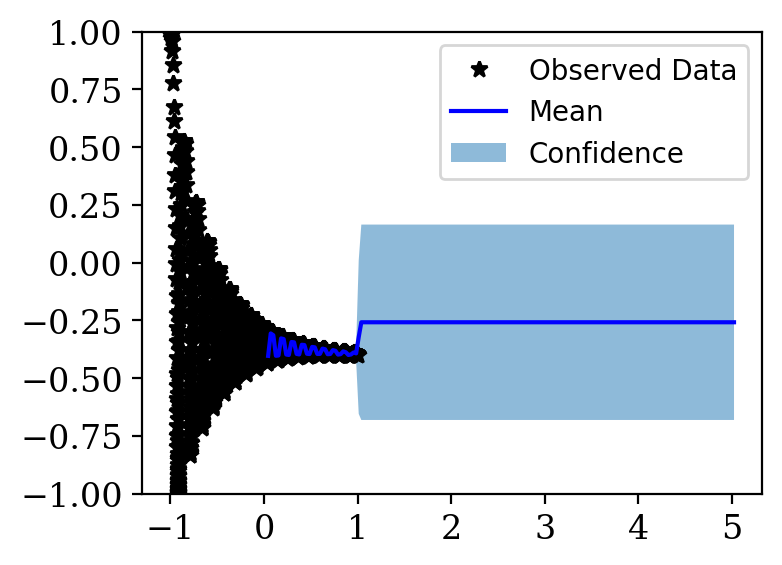

In [47]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(4, 3))
    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()

    # Flatten tensors and convert to NumPy arrays
    train_x_LF_np = train_x_LF.numpy().flatten()
    train_y_LF_np = train_y_LF.numpy().flatten()
    x_test_HF_np = x_test_HF.numpy().flatten()
    observed_mean_np = observed_pred.mean.numpy().flatten()
    
    # Plot training data as black stars
    ax.plot(train_x_LF_np, train_y_LF_np, 'k*')
    # Plot predictive means as blue line
    ax.plot(x_test_HF_np, observed_mean_np, 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(x_test_HF_np, lower.numpy().flatten(), upper.numpy().flatten(), alpha=0.5)
    ax.set_ylim([-1.0, 1.0])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

    plt.xticks(fontname = "serif", fontsize=12)
    plt.yticks(fontname = "serif", fontsize=12)
    ax.set_title("Multivariate Normal Gaussian with Posterior kernel: %s"
              % model.likelihood_, font) # Show in the title the value of the hyperparameters
    plt.savefig("multifidelity_singletask.png", bbox_inches="tight")

# Phase 4: Multitask GP Regression

In [ ]:
#Retrieve dataframes
sim_df = pd.read_csv("../Simulation_Data_0.107_13900.csv") # read pandas DataFrame for simulated data (low-fidelity)
exp_df = pd.read_csv("../Experimental_Data_10PA_.06BIS.csv") # read pandas DataFrame for experimental data (high fidelity)

Data_x = torch.cat([torch.tensor(sim_df.iloc[:, 0], dtype=torch.float32),
                    torch.tensor(exp_df.iloc[:, 0], dtype=torch.float32)])

Data_y = torch.cat([torch.tensor(sim_df.iloc[:, 1], dtype=torch.float32),
                    torch.tensor(exp_df.iloc[:, 1], dtype=torch.float32)])


# Reshape Data_x and Data_y if needed
Data_x = Data_x.view(-1, 1)
Data_y = Data_y.view(-1, 1)

print("Data_x size:", Data_x.size())
print("Data_y size:", Data_y.size())

# Let's split into x% training points and the rest for testing:
X_train, X_test, Y_train, Y_test = train_test_split(Data_x,
                                    Data_y, test_size=testset_ratio,
                                    random_state=seed)
#X_train = X_train.ravel() # just for plotting later
#X_test = X_test.ravel() # just for plotting later

# Check the shapes
print("X_train size:", X_train.size())
print("Y_train size:", Y_train.size())
output = model(X_train)
print(output)

numtasks=2
Y_train_reshaped = Y_train.view(-1, 1).expand(-1, numtasks)
print("Y_train_reshaped:", Y_train_reshaped.size())

In [ ]:
####remove once works

# Create the multi-task GP model
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=numtasks)
model = MultitaskGPModel(X_train, Y_train_reshaped, likelihood)

#checking if any attributes of the model are None
for name, param in model.named_parameters():
    print(f'{name}: requires_grad={param.requires_grad}')
for param_group in optimizer.param_groups:
    print(f'Param group: {param_group}')

In [ ]:
#####testing
for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train_reshaped)
    loss.backward()

    # Print information about parameters and gradients
    #for name, param in model.named_parameters():
       # print(f'Parameter: {name}, Grad: {param.grad}')

    # Update the gradient norm calculation
    non_empty_grads = [p.grad.flatten() for p in model.parameters() if p.grad is not None and p.requires_grad]

    if non_empty_grads:
        grad_norm = torch.norm(torch.cat(non_empty_grads))
        print('Iter %d/%d - Loss: %.3f   Gradient Norm: %.3f' % (
            i + 1, training_iterations, loss.item(), grad_norm.item()
        ))
    else:
        print('No gradients found.')

    optimizer.step()


In [ ]:
# Make predictions
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(torch.from_numpy(X_test)))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# Flatten tensors and convert to NumPy arrays
Y_train_np = Y_train.numpy().flatten()
observed_mean_np = observed_pred.mean.numpy().flatten()

# Plot training data as black stars
y1_ax.plot(X_train, Y_train_np, 'k*')
# Predictive mean as blue line
#y1_ax.plot(X_test, mean.numpy(), 'b')
y1_ax.plot(X_test_np, observed_mean_np, 'b')
# Shade in confidence
y1_ax.fill_between(X_test, lower.numpy(), upper.numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(X_train.numpy(), Y_train_np[:, 0].numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(X_test.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(X_test.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None

In [ ]:
#Make predictions with the model
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(torch.from_numpy(X_test)))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# Convert necessary arrays to PyTorch tensors
X_train_tensor = torch.from_numpy(X_train)
Y_train_reshaped_tensor = torch.from_numpy(Y_train_reshaped)
X_test_tensor = torch.from_numpy(X_test)

# Plot training data as black stars
y1_ax.plot(X_train_tensor.numpy(), Y_train_reshaped_tensor[:, 0].numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(X_test_tensor.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(X_test_tensor.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(X_train_tensor.numpy(), Y_train_reshaped_tensor[:, 0].numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(X_test_tensor.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(X_test_tensor.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')


None

In [ ]:
testset_ratio = 0.75 # ratio of test set points from the dataset
seed = 1987 # set a random seed so that everyone gets the same result
np.random.seed(seed)
numtasks=2

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, X_train, Y_train, likelihood):
        super(MultitaskGPModel, self).__init__(X_train, Y_train, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=numtasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=numtasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

# Create the multi-task GP model
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=numtasks)
model = MultitaskGPModel(X_train, Y_train_reshaped, likelihood)


#training the model hyperparameters
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Calculate and print the gradient norm
grad_norm = torch.norm(torch.cat([p.grad.flatten() for p in model.parameters() if p.grad is not None and p.requires_grad]))

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(X_train)
    loss = -mll(output, Y_train_reshaped)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f lengthscale: %.3f   noise: %.3f   Gradient Norm: %.3f' % (
    i + 1, training_iterations, loss.item()),
    model.covar_module.base_kernel.lengthscale.item(),
    model.likelihood.noise.item(),
    grad_norm.item())
    #print('Iter %d/%d - Loss: %.3f lengthscale: %.3f noise: %.3f' % (
    #i + 1, training_iterations, loss.item()),
    #model.covar_module.base_kernel.lengthscale.item(),
    #model.likelihood.noise.item())

    optimizer.step()



In [ ]:
#Make predictions with the model
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_test_HF))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
    # Flatten tensors and convert to NumPy arrays
    train_x_LF_np = train_x_LF.numpy().flatten()
    train_y_LF_reshaped_np = train_y_LF_reshaped.numpy().flatten()
    x_test_HF_np = X_test_HF.numpy().flatten()
    observed_mean_np = observed_pred.mean.numpy().flatten()
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x_LF.detach().numpy(), train_y_LF_reshaped[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(x_test_HF_np.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(x_test_HF_np.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x_LF.detach().numpy(), train_y_LF_reshaped[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(x_test_HF_np.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(x_test_HF_np.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None

In [40]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
# Ensure that the total number of elements remains the same
#assert train_y_LF.numel() % num_tasks == 0, "Number of tasks should evenly divide the total number of elements"
# Explicitly create a new tensor with the desired shape
#train_y_LF_reshaped = torch.zeros(train_y_LF.numel() // num_tasks, num_tasks)
# Populate the new tensor with the values from train_y_LF
#for i in range(num_tasks):
    #train_y_LF_reshaped[:, i] = train_y_LF[i::num_tasks]
#train_y_LF_reshaped = train_y_LF.view(-1, num_tasks)
train_y_LF_reshaped = train_y_LF.view(-1, 1).expand(-1, num_tasks)
print("Target shape:", train_y_LF_reshaped.shape)

#print(output)
#print(train_y_LF_reshaped)

In [ ]:
#define a multitask model
numtasks = 2

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x_LF, train_y_LF_reshaped, likelihood):
        super(MultitaskGPModel, self).__init__(train_x_LF, train_y_LF_reshaped, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=numtasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=numtasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=numtasks)
model = MultitaskGPModel(train_x_LF, train_y_LF_reshaped, likelihood)


print("Output shape:", output.shape)
print("Target shape:", train_y_LF.shape)

In [ ]:
#training the model hyperparameters
# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Calculate and print the gradient norm
#grad_norm = torch.norm(torch.cat([p.grad.flatten() for p in model.parameters()]))

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x_LF)
    loss = -mll(output, train_y_LF_reshaped)
    loss.backward()
    #print('Iter %d/%d - Loss: %.3f lengthscale: %.3f   noise: %.3f   Gradient Norm: %.3f' % (
    #i + 1, training_iterations, loss.item()),
    #model.covar_module.base_kernel.lengthscale.item(),
    #model.likelihood.noise.item(),
    #grad_norm.item())
    print('Iter %d/%d - Loss: %.3f lengthscale: %.3f noise: %.3f' % (
    i + 1, training_iterations, loss.item()),
    model.covar_module.base_kernel.lengthscale.item(),
    model.likelihood.noise.item())

    optimizer.step()

In [ ]:
#Make predictions with the model
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    predictions = likelihood(model(X_test_HF))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
    # Flatten tensors and convert to NumPy arrays
    train_x_LF_np = train_x_LF.numpy().flatten()
    train_y_LF_reshaped_np = train_y_LF_reshaped.numpy().flatten()
    x_test_HF_np = X_test_HF.numpy().flatten()
    observed_mean_np = observed_pred.mean.numpy().flatten()
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x_LF.detach().numpy(), train_y_LF_reshaped[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(x_test_HF_np.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(x_test_HF_np.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x_LF.detach().numpy(), train_y_LF_reshaped[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(x_test_HF_np.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(x_test_HF_np.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None

In [ ]:
#TUTORIAL ON MULTITASK GP
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

train_x = torch.linspace(0, 1, 100)

train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
], -1)

class MultitaskGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=2
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=2, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = MultitaskGPModel(train_x, train_y, likelihood)

# this is for running the notebook in our testing framework
import os
smoke_test = ('CI' in os.environ)
training_iterations = 2 if smoke_test else 50


# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)  # Includes GaussianLikelihood parameters

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

for i in range(training_iterations):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
    optimizer.step()

# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(8, 3))

# Make predictions
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1, 51)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()

# This contains predictions for both tasks, flattened out
# The first half of the predictions is for the first task
# The second half is for the second task

# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.set_ylim([-3, 3])
y1_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.set_ylim([-3, 3])
y2_ax.legend(['Observed Data', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Values (Likelihood)')

None

In [ ]:
train_x = torch.linspace(0, 1, 100)

#train_y = torch.stack([
    #torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
   # torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
#], -1)
train_y = torch.stack([
    torch.sin(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
    torch.cos(train_x * (2 * math.pi)) + torch.randn(train_x.size()) * 0.2,
],-1)

print(train_x.shape)
print(train_y.shape)
print(train_x)
print(train_y)

In [ ]:
#botorch
from botorch.models import SingleTaskGP
from botorch.fit import fit_gpytorch_mll
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood

#fit model
train_X = torch.rand(10, 2)
Y = 1 - torch.linalg.norm(train_X - 0.5, dim=-1, keepdim=True)
Y = Y + 0.1 * torch.randn_like(Y)  # add some noise
train_Y = standardize(Y)

gp = SingleTaskGP(train_X, train_Y)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)

In [ ]:
#construct acquisition function
from botorch.acquisition import UpperConfidenceBound

UCB = UpperConfidenceBound(gp, beta=0.1)

In [ ]:
#optimize acquisition function
from botorch.optim import optimize_acqf

bounds = torch.stack([torch.zeros(2), torch.ones(2)])
candidate, acq_value = optimize_acqf(
    UCB, bounds=bounds, q=1, num_restarts=5, raw_samples=20,
)
candidate  # tensor([0.4887, 0.5063])

<p id='Phase 4: Comparing Error Metrics'></p>

# Phase 4: Comparing Error Metrics

### # Phase 5: Different Materials? More data files? Different shear moduli/viscosity (hyperparameters?)
## Slides (12) for presentation: 2 GP (M), 4 data-assim (V), 4 - multi-fidelity (M), 2 - ? (V)
### want understanding: why chose those algorithms, compare algorithms, explain new methods used

# Things to Do
- [12/01] use new experimental data from Bachir (10%/0.06% PA/BIS)
- [12/01] scale new experimental data ?
- [12/01] change simulated data that this notebook takes to be the one that corresponds most closely to the G and mu of Bachir's exp data
- [12/03] change f_min optimizer to be lgbs in scikit-learn side and in gpytorch side
- [N/A] duplicate gpytorch in multiple kernels to compare with scikit-learn
- [12/03] go back and add error metrics for all GP algorithms
- scale data using StandardScaler in scikit-learn ->
- will have to figure out how to scale for GPyTorch
- [12/05-6] change figure characteristics to produce consistent pretty pictures
- catalog and compare error metrics for all GP algorithms
- better understand multitask GP Regression and try to implement
- if have time, try fully bayesian GP to sample hyperparameters